## Imports

In [1]:
import functools
import os

from clu import metric_writers
import numpy as np
import jax
import jax.numpy as jnp
from jax.experimental import sparse
import matplotlib.pyplot as plt
import optax
import orbax.checkpoint as ocp

import h5py
import natsort
import tensorflow as tf
from scipy.ndimage import geometric_transform
from scipy.ndimage import gaussian_filter

2024-04-18 11:19:43.468168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%cd ..

/home/meliao/projects/ISP_baseline


/home/meliao/miniconda3/envs/jax_inv_scat/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src import models
from src import trainers
from WideBNetModel import morton
from WideBNetModel import WideBNet 

from swirl_dynamics import templates
from swirl_dynamics.lib import metrics
from pysteps.utils.spectral import rapsd

Pysteps configuration file found at: /home/meliao/miniconda3/envs/jax_inv_scat/lib/python3.11/site-packages/pysteps/pystepsrc



In [4]:
jax.devices()

[cuda(id=0)]

### Dataset

In [5]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

idx_flatten_to_morton = morton.flatten_to_morton_indices(L, s)
idx_morton_to_flatten = morton.morton_to_flatten_indices(L, s)

# Standard deviation for the Gaussian blur.
## OJM CHANGE: WideBNet paper reports using Gaussian kernel with characteristic width 0.75
# blur_sigma = 0.5
blur_sigma = 0.75

# Batch size.
batch_size = 32

# Number of training datapoints.
## OJM CHANGE: In the paper, this is 21,000
# NTRAIN = 20000
NTRAIN = 21_000

# Number of testing datapoints.
#NTEST = 512
# Total number
#NTOTAL = NTRAIN + NTEST

In [6]:
tf.config.set_visible_devices([], device_type='GPU')

# OJM CHANGE: Update path to training data
# name = '../data/3510tri'
name = '/net/projects/willettlab/meliao/recursive-linearization/traindata_L3s10_multifreq_square_3_5_10_h_freq_2.5_5_10/'

# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re = np.stack([blur_fn(eta_re[i, :, :]) for i in range(NTRAIN)]).astype('float32')


mean_eta, std_eta = np.mean(eta_re), np.std(eta_re)

eta_re -= mean_eta
eta_re /= std_eta


# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:NTRAIN, :]
    tmp2 = f[keys[4]][:NTRAIN, :]
    tmp3 = f[keys[5]][:NTRAIN, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:NTRAIN, :]
    tmp2 = f[keys[1]][:NTRAIN, :]
    tmp3 = f[keys[2]][:NTRAIN, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    
    # Combine real and imaginary parts
    scatter = np.stack((scatter_re, scatter_im), axis=1).astype('float32')


mean0, std0 = np.mean(scatter[:,:,:,0]), np.std(scatter[:,:,:,0])
mean1, std1 = np.mean(scatter[:,:,:,1]), np.std(scatter[:,:,:,1])
mean2, std2 = np.mean(scatter[:,:,:,2]), np.std(scatter[:,:,:,2])

scatter[:,:,:,0] -= mean0
scatter[:,:,:,0] /= std0

scatter[:,:,:,1] -= mean1
scatter[:,:,:,1] /= std1

scatter[:,:,:,2] -= mean2
scatter[:,:,:,2] /= std2


# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [7]:
dict_data = {"eta": eta_re}
dict_data["scatter"] = scatter
dataset = tf.data.Dataset.from_tensor_slices(dict_data)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()
dataset = dataset.prefetch(tf.data.AUTOTUNE)
dataset = eval_dataloader = dataset.as_numpy_iterator()

2024-04-18 11:20:49.809027: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3225600000 exceeds 10% of free system memory.
2024-04-18 11:20:51.073679: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3225600000 exceeds 10% of free system memory.


### Architecture

In [8]:
core_module = WideBNet.WideBNetModel(
     L = L, s = s, r = r, NUM_RESNET = 3, NUM_CNN = 3, idx_morton_to_flatten = idx_morton_to_flatten
)

In [9]:
Model = models.DeterministicModel(
    input_shape = scatter[0].shape,
    core_module = core_module
)

In [10]:
rng = jax.random.PRNGKey(888)
params = Model.initialize(rng)
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print('Number of trainable parameters:', param_count)

2024-04-18 11:20:57.651917: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Number of trainable parameters: 1914061


### Training

In [11]:
## OJM CHANGE: Computing the number of training steps
n_steps_per_epoch = NTRAIN / batch_size
print("Number of training steps:", n_steps_per_epoch * 150) # using 150 epochs

Number of training steps: 98437.5


In [12]:
## OJM CHANGE: Re-setting the number of training steps
# num_train_steps = 120001  #@param
num_train_steps = 98_438 #@param
workdir = os.path.abspath('') + "/tmp/WideBNet3510tri"  #@param
init_value = 5e-3
transition_steps = 2000
decay_rate = 0.95
ckpt_interval = 2000  #@param
max_ckpt_to_keep = 3   #@param

In [13]:
trainer = trainers.DeterministicTrainer(
    model=Model, 
    rng=jax.random.PRNGKey(42), 
    optimizer=optax.adam( 
        learning_rate=optax.exponential_decay(
            init_value = init_value, 
            transition_steps = transition_steps, 
            decay_rate = decay_rate, 
            staircase = True),
    ),
)
     

In [14]:
templates.run_train(
    train_dataloader=dataset,
    trainer=trainer,
    workdir=workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        workdir, asynchronous=False
    ),
    metric_aggregation_steps = 100,
    eval_dataloader = eval_dataloader,
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
            eval_monitors=("eval_rrmse_mean",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

  0%|          | 0/98438 [00:00<?, ?step/s]

### Inference

In [15]:
trained_state = trainers.TrainState.restore_from_orbax_ckpt(
    f"{workdir}/checkpoints", step=None
)

In [16]:
inference_fn = trainers.DeterministicTrainer.build_inference_fn(
    trained_state, core_module
)

In [17]:
# Loading and preprocessing perturbation data (eta)

## OJM CHANGE: update test path. Test dataset downloaded from Matt Li's github repo:
# https://github.com/mtcli/Inverse_Scattering_ML_TF2/tree/master/public-example/testdata
# name_test = '../data/3510tri_test'
name_test = '/home/meliao/projects/Inverse_Scattering_ML_TF2/public-example/testdata/'

with h5py.File(f'{name_test}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re = f[list(f.keys())[0]][:, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_test = np.stack([blur_fn(img) for img in eta_re]).astype('float32')
    
# Loading and preprocessing scatter data (Lambda)
with h5py.File(f'{name_test}/scatter.h5', 'r') as f:
    keys = natsort.natsorted(f.keys())

    # Process real part of scatter data
    tmp1 = f[keys[3]][:, :]
    tmp2 = f[keys[4]][:, :]
    tmp3 = f[keys[5]][:, :]
    scatter_re = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_re = scatter_re[:, idx_flatten_to_morton, :]
    # Process imaginary part of scatter data
    tmp1 = f[keys[0]][:, :]
    tmp2 = f[keys[1]][:, :]
    tmp3 = f[keys[2]][:, :]
    scatter_im = np.stack((tmp3, tmp2, tmp1), axis=-1)
    scatter_im = scatter_im[:, idx_flatten_to_morton, :]
    # Combine real and imaginary parts
    scatter_test = np.stack((scatter_re, scatter_im), axis=1).astype('float32')
    
# Clean up temporary variables to free memory
del scatter_re, scatter_im, tmp1, tmp2, tmp3

scatter_test[:,:,:,0] -= mean0
scatter_test[:,:,:,0] /= std0

scatter_test[:,:,:,1] -= mean1
scatter_test[:,:,:,1] /= std1

scatter_test[:,:,:,2] -= mean2
scatter_test[:,:,:,2] /= std2


In [18]:
test_batch = 100
test_dataset = tf.data.Dataset.from_tensor_slices((scatter_test, eta_test))
test_dataset = test_dataset.batch(test_batch)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.as_numpy_iterator()

In [19]:
## OJM CHANGE: Add two helper functions for computing 'Pixelwise square loss' and 'Imagewise relative loss' 
## as described in the WideBNet paper

def imagewise_rel_loss(pred, target):
    """pred has shape (batch, n_eta, n_eta)
        target has shape (batch, n_eta, n_eta)
        return value has shape (batch,)
    """
    target_nrms = np.square(np.linalg.norm(target, axis=(-2,-1)))
    diff_nrms = np.square(np.linalg.norm(target - pred, axis=(-2,-1)))
    return diff_nrms / target_nrms

def pixelwise_sq_loss(pred, target):
    """pred has shape (batch, n_eta, n_eta)
        target has shape (batch, n_eta, n_eta)
        return value has shape (batch,)
    """
    diff_nrms = np.square(np.linalg.norm(target - pred, axis=(-2,-1)))
    return diff_nrms

In [20]:
## OJM CHANGE: Added lines in the loop where 'Pixelwise square loss' and 'Imagewise relative loss' are computed
## for each sample.
validation_errors_rrmse = [] 
validation_errors_rapsd = [] 
pixelwise_sq_loss_vals = []
imagewise_rel_loss_vals = []
eta_pred = np.zeros(eta_test.shape)

rrmse = functools.partial(
        metrics.mean_squared_error,
        sum_axes=(-1, -2),
        relative=True,
        squared=False,
    )

b = 0
for batch in test_dataset:
    pred = inference_fn(batch[0]) * std_eta + mean_eta
    eta_pred[b*test_batch:(b+1)*test_batch,:,:] = pred
    b += 1
    true = batch[1]
    ## OJM CHANGE: Added the next 4 lines.
    xx = pixelwise_sq_loss(pred, true)
    pixelwise_sq_loss_vals.append(xx)
    yy = imagewise_rel_loss(pred, true)
    imagewise_rel_loss_vals.append(yy)
    validation_errors_rrmse.append(rrmse(pred=pred, true=true))
    for i in range(true.shape[0]):
        validation_errors_rapsd.append(np.abs(np.log(rapsd(pred[i],fft_method=np.fft)/rapsd(true[i],fft_method=np.fft))))

print('relative root-mean-square error = %.3f' % (np.mean(validation_errors_rrmse)*100), '%') 
print('radially averaged power spectrum = %.3f' % np.mean(validation_errors_rapsd)) 


relative root-mean-square error = 7.582 %
radially averaged power spectrum = 0.205


2024-04-18 11:34:05.370810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
## OJM CHANGE: Computing and reporting Pixelwise square loss and Imagewise relative loss averaged over the test set.
pixelwise_sq_loss_vec = np.array(pixelwise_sq_loss_vals).flatten()
print("Mean pixelwise squared loss on test dataset:", np.mean(pixelwise_sq_loss_vec))

imagewise_rel_loss_vec = np.array(imagewise_rel_loss_vals).flatten()
print("Mean imagewise relative loss on test dataset:", np.mean(imagewise_rel_loss_vec))

Mean pixelwise squared loss on test dataset: 0.028363174
Mean imagewise relative loss on test dataset: 0.005755983


In [22]:
with h5py.File("results_widebnet_3510tri.h5", "w") as f:
    f.create_dataset('eta', data=eta_test)
    f.create_dataset('eta_pred', data=eta_pred)

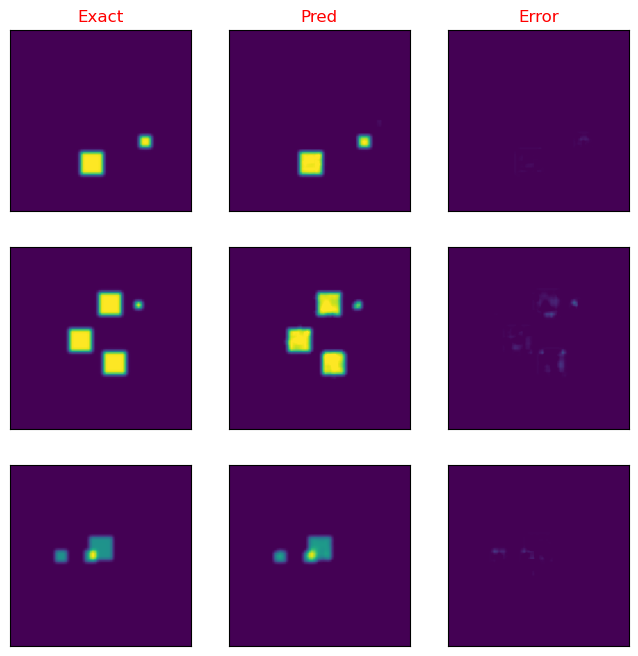

In [23]:
fig = plt.figure(figsize=(8,8))
NPLOT = 3
for kk in range(NPLOT):
    plt.subplot(NPLOT, 3, kk*NPLOT + 1)
    plt.imshow(batch[1][kk,:,:])
    plt.xticks([]); plt.yticks([]); clim = plt.gci().get_clim();
    if kk == 0:
        plt.title('Exact', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 2)
    plt.imshow(pred[kk,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Pred', color='red')

    plt.subplot(NPLOT, 3, kk*NPLOT + 3)
    plt.imshow(batch[1][kk,:,:]-pred[kk,:,:])
    plt.xticks([]); plt.yticks([]); plt.gci().set_clim(clim);
    if kk == 0:
        plt.title('Error', color='red')                
plt.show()
fig.savefig('widebnet3510tri.png')